In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
from astropy.visualization import AsymmetricPercentileInterval, ZScaleInterval

import numpy as np
import os.path
import glob
import cv2

from astropy.io import fits
from astropy.wcs import WCS

In [2]:
def border2mask(filename, plot_mask = False, return_mask = False):
    # read and scale the image
    ext = os.path.splitext(filename)[1]
    if ext == '.fz':
        hdu = fits.open(filename)[1]
    else:
        hdu = fits.open(filename)[0]    

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    zscale = ZScaleInterval ( contrast = 0.35 )  
    zdata = zscale(data)

    img = np.asarray ( zdata, dtype = np.uint8 ) 
    thresh = cv2.threshold ( img, 0, 255, cv2.THRESH_BINARY)[1]

    # get bounding box coordinates from largest external contour
    contours = cv2.findContours ( thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max ( contours, key = cv2.contourArea )
    x, y, w, h = cv2.boundingRect ( big_contour )
    
    mask = np.zeros ( data.shape, dtype = '<f' )
    mask[x:x+w, y:y+h] = data[x:x+w, y:y+h]
    
    mask_file = os.path.splitext(filename)[0] + '_BMASK' + ext
    
    if ext == '.fz':
        imageHeader = fits.Header()
        hdu = fits.CompImageHDU ( mask, header )
        hdu.writeto ( mask_file, overwrite = True )
    else:
        fits.writeto ( mask_file, mask, hdu.header, overwrite = True ) 

    print ( '[+] File created: ', mask_file )
    
    if plot_mask:
        vmin, vmax = AsymmetricPercentileInterval ( lower_percentile = 50, upper_percentile = 95 ).get_limits ( zdata )
        args = dict( origin = 'lower',  cmap='gray', norm = colors.LogNorm(vmin = vmin, vmax = vmax, clip = True) )

        fig, ((ax0, ax1),  (ax2, ax3)) = plt.subplots ( ncols = 2, nrows = 2, figsize = (15, 10), dpi = 80, sharey = True )
        for a, b, c, d, ax in [[8500, 11000, 0, 2500,ax0], [8500, 11000, 8500, 11000, ax1], 
                               [0, 2500, 0, 2500, ax2], [0, 2500, 8500, 11000, ax3]]:
            ax.imshow ( zdata[a:b, c:d], **args )
            if (ax == ax1) | (ax == ax2):
                ax.add_patch ( Rectangle( (x-a, y-c), w, h, edgecolor = 'red', facecolor = 'none', lw = 2) )
            elif ax == ax3:
                ax.add_patch ( Rectangle( (x-a-8500, y-c+8500), w, h, edgecolor = 'red', facecolor = 'none', lw = 2) )
            elif ax == ax0:
                ax.add_patch ( Rectangle( (x-a+8500, y-c-8500), w, h, edgecolor = 'red', facecolor = 'none', lw = 2) )
        plt.tight_layout()
        plt.show()
        
    if return_mask:
        return mask

In [3]:
glob.glob("images/*.fz")

['images/SPLUS-s26s34_R_swp.fz',
 'images/SPLUS-s27s34_R_swp.fz',
 'images/SPLUS-s26s35_R_swp.fz',
 'images/SPLUS-s27s35_R_swp.fz',
 'images/SPLUS-s28s32_R_swp.fz',
 'images/SPLUS-s29s31_R_swp.fz',
 'images/SPLUS-s28s34_R_swp.fz',
 'images/SPLUS-s27s33_R_swp.fz',
 'images/SPLUS-s28s33_R_swp.fz']

[+] File created:  images/SPLUS-s26s34_R_swp_BMASK.fz


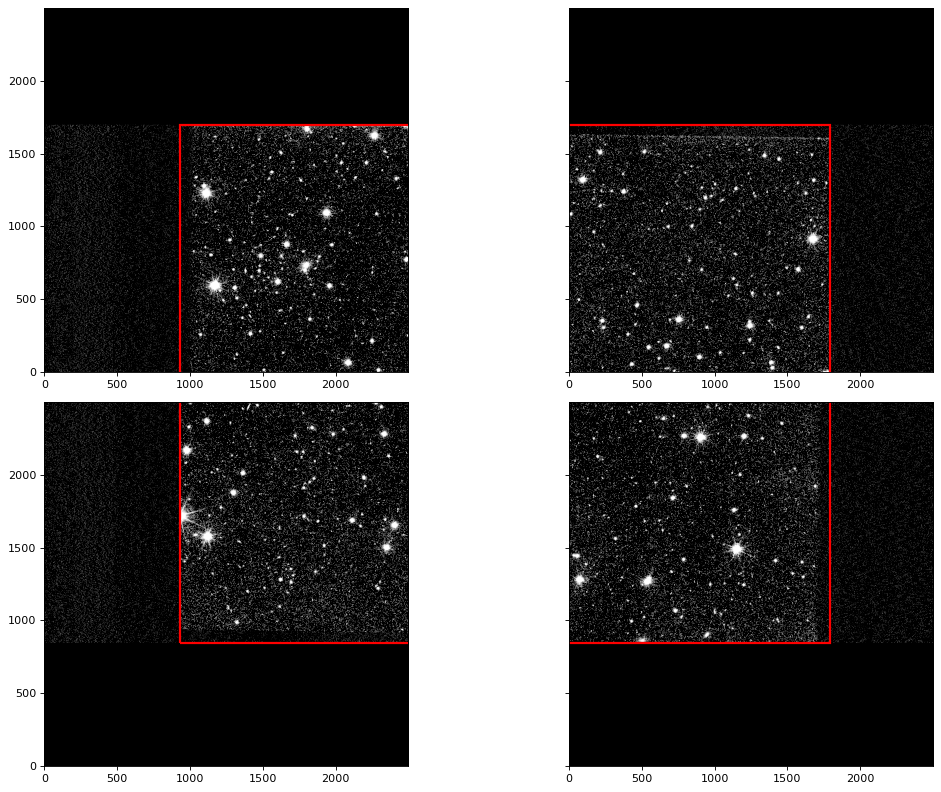

[+] File created:  images/SPLUS-s27s34_R_swp_BMASK.fz


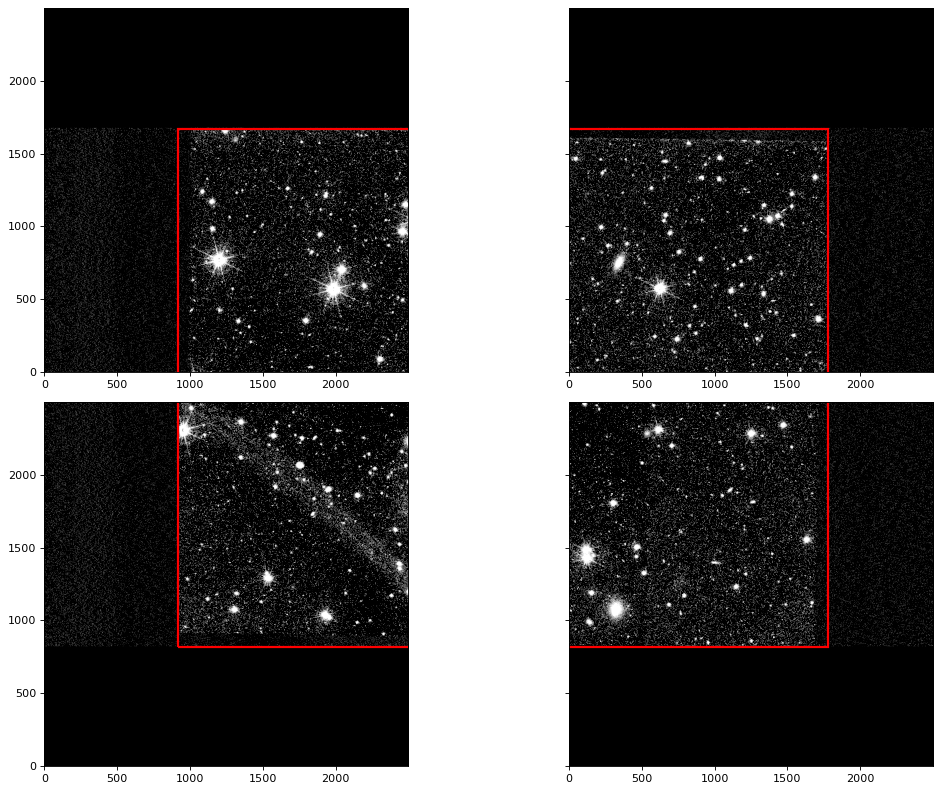

[+] File created:  images/SPLUS-s26s35_R_swp_BMASK.fz


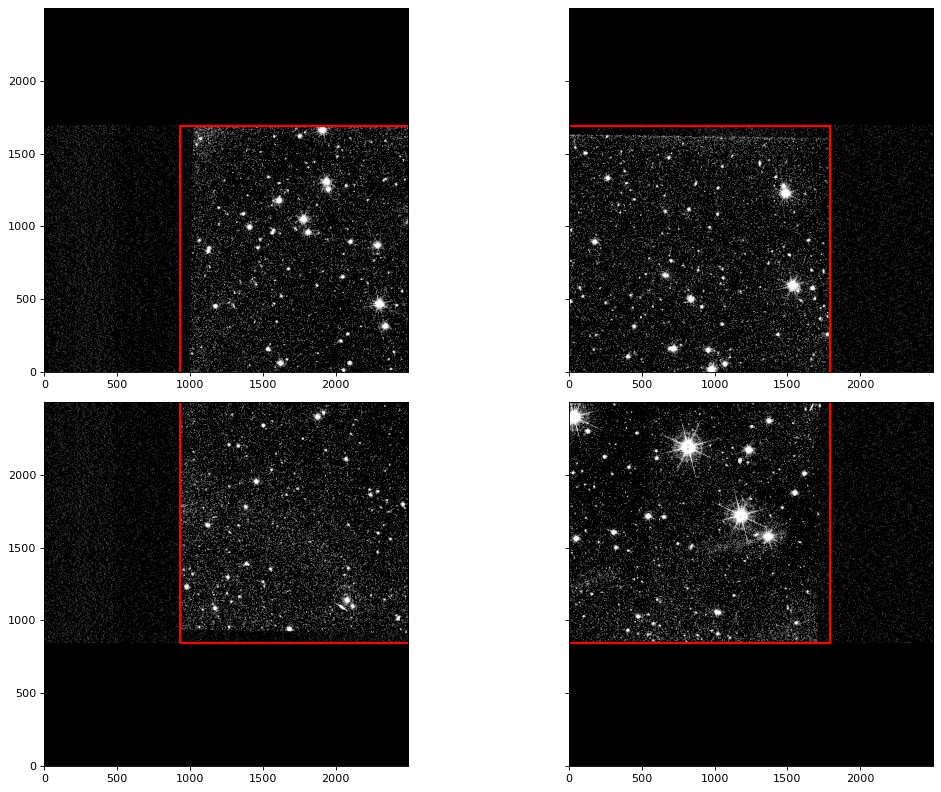

[+] File created:  images/SPLUS-s27s35_R_swp_BMASK.fz


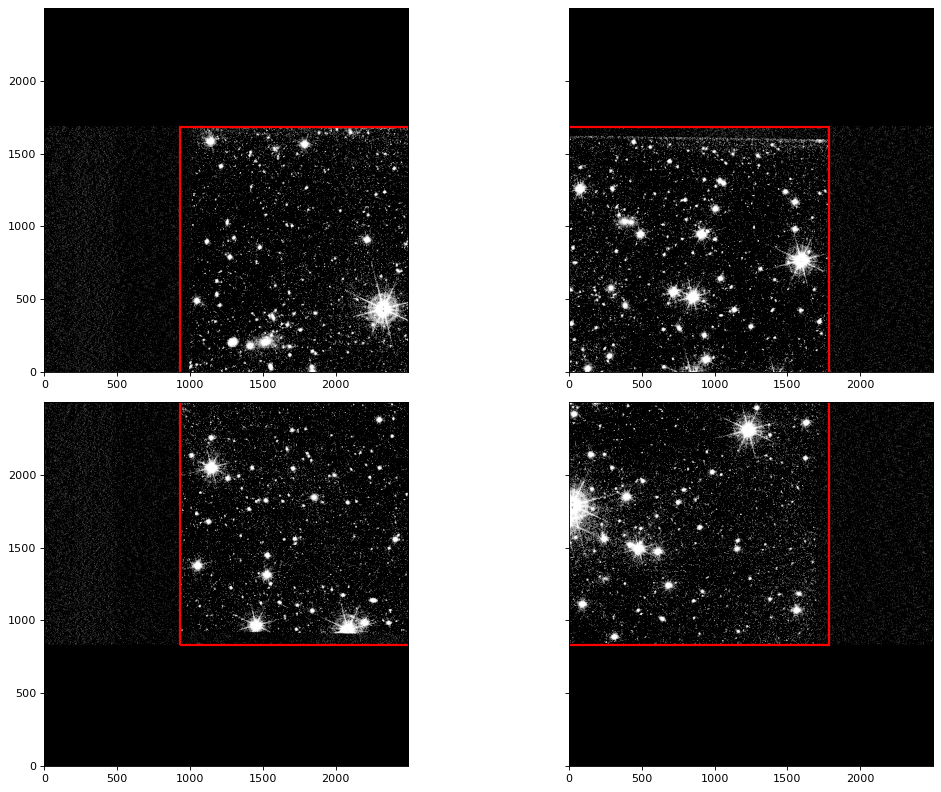

[+] File created:  images/SPLUS-s28s32_R_swp_BMASK.fz


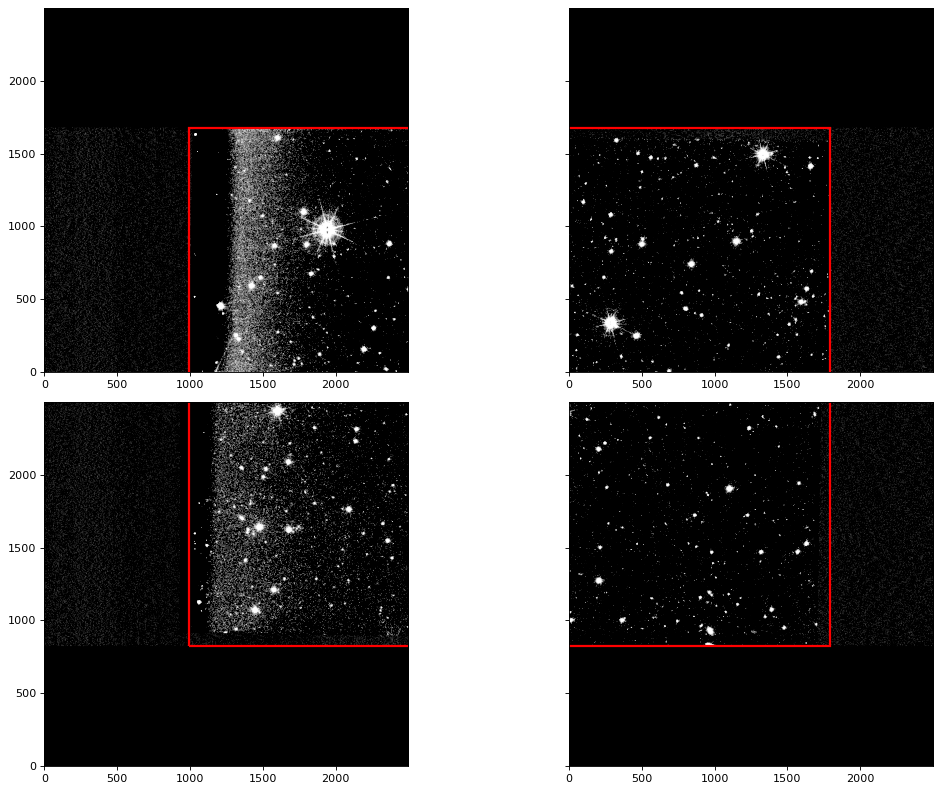

[+] File created:  images/SPLUS-s29s31_R_swp_BMASK.fz


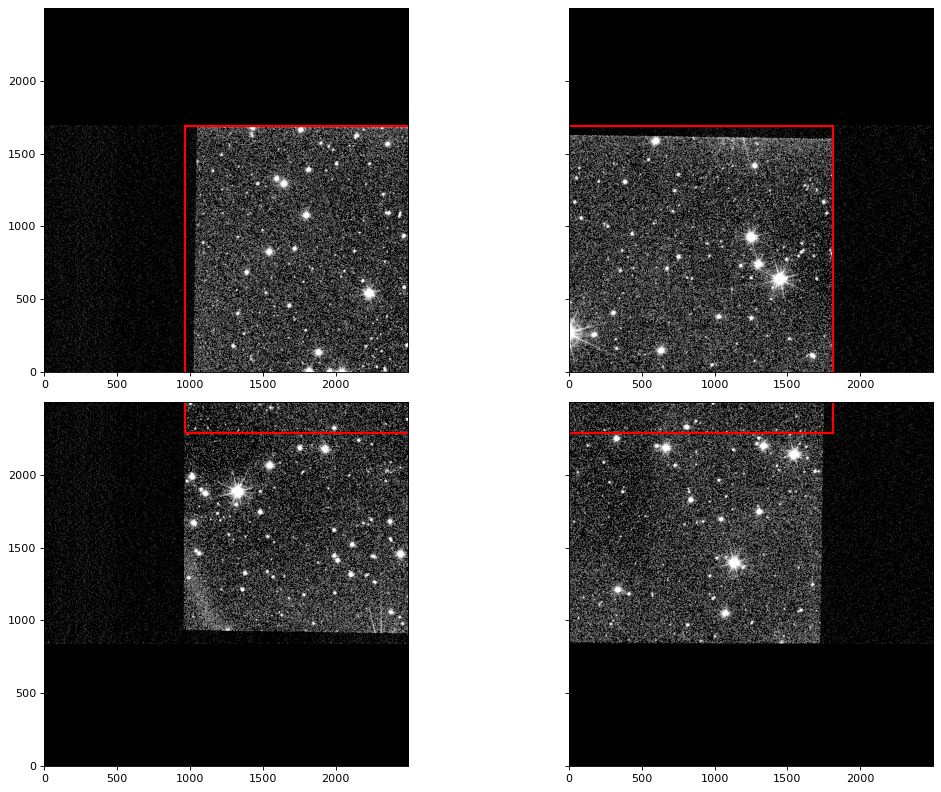

[+] File created:  images/SPLUS-s28s34_R_swp_BMASK.fz


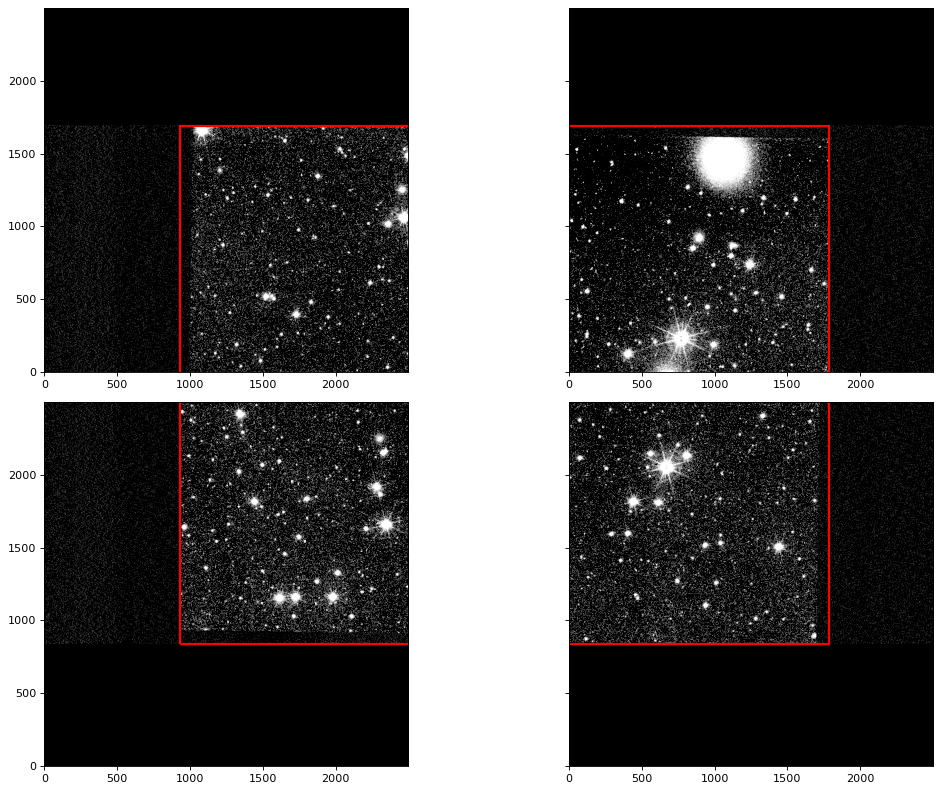

[+] File created:  images/SPLUS-s27s33_R_swp_BMASK.fz


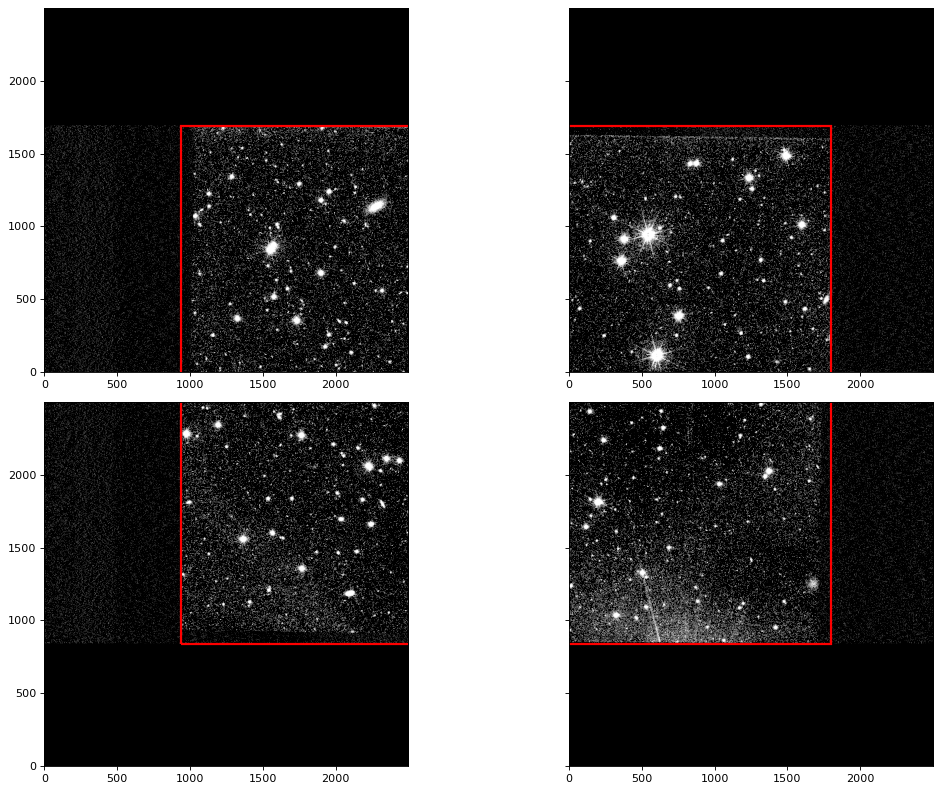

[+] File created:  images/SPLUS-s28s33_R_swp_BMASK.fz


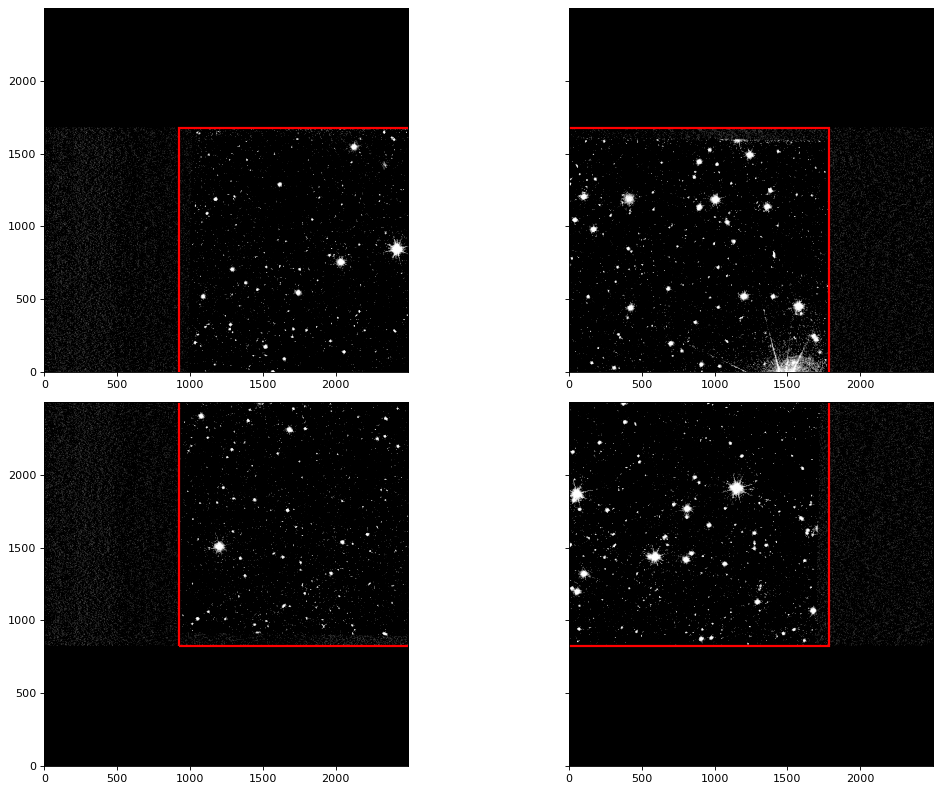

In [4]:
for filename in glob.glob("images/*.fz"):
    border2mask(filename, plot_mask = True, return_mask = False)